In [1]:
import sys
sys.path.append('../src/') # for graph_data

import graph_data as gd
import time
import torch
from models import TreeSupport
from torch import optim
from torch.nn import BCELoss
from torch.utils.data import random_split, ConcatDataset
from torch_geometric.data import DataLoader
from Bio import Phylo as phy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('text', usetex=True)

torch.manual_seed(245)

# Datasets
## Prepare trees and reconstructed sequences

In [2]:
data_path = '../data/'

In [3]:
target_tree = phy.read(data_path+'tree/Fungi45_infer/Fungi.tre', 'newick')
#fungi_data = gd.Trees.load_ready_trees(data_path+'tree/Fungi45_infer/fml_output/', data_path+'tree/Fungi45_infer/fml_output/*.tre', target_tree)  # INITIALIZE NEW DS
fungi_data = gd.Trees(data_path+'tree/Fungi45_infer/', data_path+'alns/Fungi45/', target_tree)

# get binned values
l = list()
for d in fungi_data:
    nodes = torch.stack(torch.unique(d.edge_index[0], return_counts=True))
    internodes = nodes[0, nodes[1]!=1]
    l += d.y[internodes].squeeze().tolist()
med = np.median(l)
fungi_data.data.y = (fungi_data.data.y > med).float()
fungi_data.data.x = fungi_data.data.x.float()
fungi_data.data.edge_attr = (torch.max(fungi_data.data.edge_attr)+0.001 - fungi_data.data.edge_attr).float()
fungi_data.data.edge_index = fungi_data.data.edge_index.long()

In [4]:
target_tree = phy.read(data_path+'tree/Archaea/Archaea.tre', 'newick')
#archaea_data = gd.Trees.load_ready_trees(data_path+'tree/Archaea/fml_output/', data_path+'tree/Archaea/fml_output/*.tre', target_tree)  # INITIALIZE NEW DS //delete temp_tree
archaea_data = gd.Trees(data_path+"tree/Archaea/", data_path+"alns/Archaea/", target_tree)

# get binned values
l = list()
for d in archaea_data:
    nodes = torch.stack(torch.unique(d.edge_index[0], return_counts=True))
    internodes = nodes[0, nodes[1]!=1]
    l += d.y[internodes].squeeze().tolist()
med = np.median(l)
archaea_data.data.y = (archaea_data.data.y > med).float()
archaea_data.data.x = archaea_data.data.x.float()
archaea_data.data.edge_attr = (torch.max(archaea_data.data.edge_attr)+0.001 - archaea_data.data.edge_attr).float()
archaea_data.data.edge_index = archaea_data.data.edge_index.long()

In [5]:
# concatenate datasets
all_data =  ConcatDataset([fungi_data, archaea_data])

In [6]:
# data preparation
train_batch = 50
test_batch = 50
# data loaders
train, test = random_split(
    all_data, [round(len(all_data) * 0.8), round(len(all_data) * 0.2)]
)

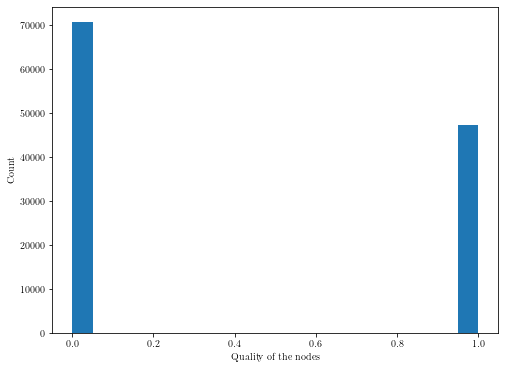

In [7]:
lst = list()
for i, data in enumerate(train):
    nodes = torch.stack(torch.unique(data.edge_index[0], return_counts=True))
    internodes = nodes[0, nodes[1]!=1]
    lst += data.y[internodes].squeeze().tolist()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
plt.hist(lst, bins=20)
ax.set_xlabel('Quality of the nodes')
ax.set_ylabel('Count')
plt.savefig('quality.png')

In [8]:
train_dl = DataLoader(
    train, batch_size=train_batch, pin_memory=True, num_workers=3
)
test_dl = DataLoader(
    test, batch_size=test_batch, num_workers=2
)

In [9]:
model = TreeSupport(231, 400)
model = model.cuda()
silent = False
num_epochs = 400
loss_fn = BCELoss()
test_batches = len(test_dl)
# stattr
losses = []
val_losses = []
learning_rates = []

In [ ]:
# interactive descending lr for less loss
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.5, verbose=True, cooldown=2, patience=5
)
start = time.time()
for epoch in range(num_epochs):
    model.train()
    for data in train_dl:
        data = data.to(torch.device('cuda'))
        optimizer.zero_grad()
        nodes = torch.stack(torch.unique(data.edge_index[0], return_counts=True))
        internodes = nodes[0, nodes[1]!=1]
        out = model(data)
        loss = loss_fn(out[internodes], data.y[internodes])
        losses.append(loss.item())  # history
        # optimize
        loss.backward()
        optimizer.step()

        # stats
        learning_rates.append(-1)

    # evaluation
    model.eval()
    agg_loss = 0
    with torch.autograd.no_grad():
        for data in test_dl:
            data = data.to(torch.device('cuda'))
            out = model(data)
            agg_loss += loss_fn(out, data.y)
        val_losses.append(agg_loss.item()/test_batches)
    scheduler.step(agg_loss)
    if not silent:
        print(
            "Epoch [{}/{}], Loss (last training batch/val): {:.4f}/{:.4f}. Time elapsed: {:.2f}".format(
                epoch + 1,
                num_epochs,
                losses[-1],
                val_losses[-1],
                time.time() - start,
            )
        )

# Learning stats

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)

plt.plot(
    range(1, len(val_losses)+1), 
    list(map(
        lambda i: np.mean(losses[i:i+len(train_dl)]),
        range(0, len(losses)-len(train_dl)+1, len(train_dl))
    ))
)
plt.plot(range(1, len(val_losses)+1), val_losses)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
plt.savefig('loss.png')

In [ ]:
torch.save(model.state_dict(), '../models/NewTry_NF.dct')

In [10]:
model.load_state_dict(torch.load('../models/NewTry_NF.dct'))

<All keys matched successfully>

## Test with completely different data

In [11]:
from sklearn import metrics

## Eukaryota

In [12]:
# data
target_tree = phy.read(data_path+'tree/Other_eukaryota_2018.tre', 'newick')
test_dataset = gd.Trees(
    data_path+"tree/Eukaryota/",
    data_path+"alns/other_eukaryota_2018/",
    target_tree
)
# transform to feed into the model
l = list()
for d in test_dataset:
    nodes = torch.stack(torch.unique(d.edge_index[0], return_counts=True))
    internodes = nodes[0, nodes[1]!=1]
    l += d.y[internodes].squeeze().tolist()
med = np.median(l)
test_dataset.data.y = (test_dataset.data.y > med).float()
test_dataset.data.x = test_dataset.data.x.float()
test_dataset.data.edge_attr = (torch.max(test_dataset.data.edge_attr)+0.001 - test_dataset.data.edge_attr).float()
test_dataset.data.edge_index = test_dataset.data.edge_index.long()
test_dl = DataLoader(
    test_dataset, batch_size=50, num_workers=2
)

In [13]:
model.eval()
nplist = list()
for data in test_dl:
    with torch.no_grad():
        data.x, data.edge_index, data.edge_attr = data.x.float(), data.edge_index.long(), data.edge_attr.float()  # CLEAN IT!!!!!
        out = model(data.to(torch.device('cuda')))
        nodes = torch.stack(torch.unique(data.edge_index[0], return_counts=True))
        internodes = nodes[0, nodes[1]!=1]
        
        nplist.append(np.concatenate([data.y[internodes].cpu().numpy(), out[internodes].detach().cpu().numpy()], axis=1))
test_results = pd.DataFrame(np.concatenate(nplist, 0), columns=['actual', 'predicted'])
test_results.describe()

/hspart/tools/miniconda3/envs/geom/lib/python3.8/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


,actual,predicted
count,131692.000000,131692.000000
mean,0.427740,0.318568
std,0.494753,0.280185
min,0.000000,0.002680
25%,0.000000,0.084807
50%,0.000000,0.301507
75%,1.000000,0.400087
max,1.000000,0.999739


In [14]:
test_results = pd.DataFrame(np.concatenate(nplist), columns=['actual', 'predicted'])

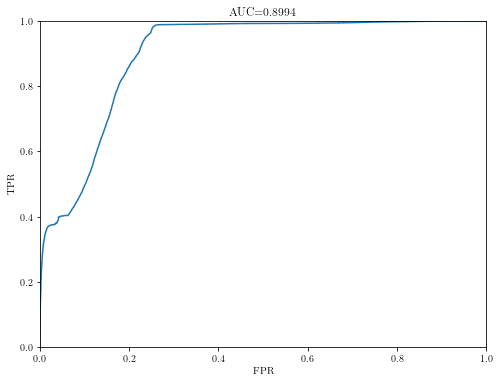

In [15]:
fpr, tpr, thresholds_roc = metrics.roc_curve(test_results["actual"], test_results["predicted"])

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)

plt.plot(fpr, tpr)
plt.title('AUC={:.4f}'.format(metrics.roc_auc_score(test_results["actual"], test_results["predicted"])))
plt.xlim(0, 1)
plt.ylim(0, 1)
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
plt.savefig('roc_eukaryota.png')

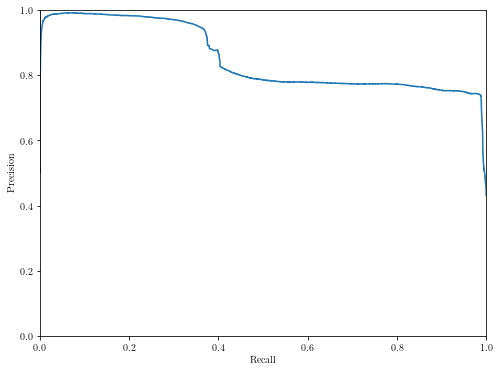

In [16]:
prec, rec, thresholds_recprec = metrics.precision_recall_curve(test_results["actual"], test_results["predicted"])
roc_data = pd.DataFrame({"Precision": prec, "Recall": rec})
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)

plt.plot(rec, prec)
plt.xlim(0, 1)
plt.ylim(0, 1)
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
plt.savefig('recprec_eukaryota.png')

In [25]:
optimal_thr = thresholds_roc[np.argmax(tpr-fpr)]
optimal_thr

0.28154972

In [26]:
metrics.confusion_matrix(test_results["actual"], test_results["predicted"]>=optimal_thr)

array([[56181, 19181],
       [  984, 55346]])

In [27]:
metrics.accuracy_score(test_results["actual"], test_results["predicted"]>=optimal_thr)

0.8468775627980439

In [28]:
metrics.f1_score(test_results["actual"], test_results["predicted"]>=optimal_thr)

0.8459004867909244

### Whole tree quality correlations. Eukaryota

## calculate RF distances
import dendropy
import glob

# model to cpu
model = model.cpu()

target_tree = dendropy.Tree.get(path=data_path+'tree/Other_eukaryota_2018.tre', schema='newick')
tree_files = glob.glob(data_path+"tree/Eukaryota/*.tre")
trees = dendropy.Tree.yield_from_files(tree_files, schema='newick', taxon_namespace=target_tree.taxon_namespace)

In [30]:
rf_distances = {file:dendropy.calculate.treecompare.symmetric_difference(target_tree, tree) for file, tree in zip(tree_files, trees)}

In [31]:
rf_distances = pd.DataFrame({'distance': rf_distances})

In [32]:
with torch.no_grad():
    predicted = {tree.filename[0]: torch.sum(model(tree)).item() for tree in test_dataset}
predicted = pd.DataFrame({'predicted_inc_nodes': predicted})

/hspart/tools/miniconda3/envs/geom/lib/python3.8/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [33]:
data = pd.merge(
    rf_distances, predicted,
    how='inner', left_index=True,
    right_index=True)

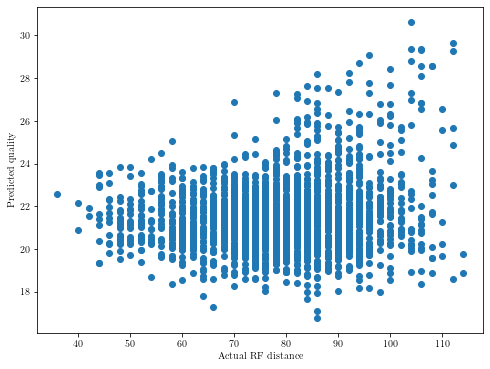

In [34]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)

plt.scatter(data['distance'], data['predicted_inc_nodes'])
ax.set_xlabel('Actual RF distance')
ax.set_ylabel('Predicted quality')
plt.savefig('Eukaryota_corr.png')

In [35]:
from scipy.stats import spearmanr

In [36]:
spearmanr(data['distance'], data['predicted_inc_nodes'])

SpearmanrResult(correlation=0.10710300427677212, pvalue=4.1598851509328995e-07)

# Example of a prediction

In [39]:
import networkx as nx
import dendropy

with torch.no_grad():
    predictions = model(test_dataset[0])
    
G = nx.Graph()
G.add_nodes_from(range(test_dataset[0].x.shape[0]))
ei = test_dataset[0].edge_index.numpy().T
G.add_edges_from(ei[:len(ei)//2])
G=G.to_undirected()
p = nx.nx_pydot.to_pydot(G)

model = model.cpu()

nodes = p.get_nodes()
for i in range(len(nodes)):
    nodes[i].set_style('filled')
    if predictions[i]>=optimal_thr:
        if test_dataset[0].y[i]==1:
            nodes[i].set_fillcolor('green')
        else:
            nodes[i].set_fillcolor('blue')
    if predictions[i]<optimal_thr:
        if test_dataset[0].y[i]==1:
            nodes[i].set_fillcolor('red')
            
# write tree
p.write_png('tree.png')

# the etalon tree
t = dendropy.Tree.get_from_path(test_dataset[0].filename[0], 'newick')
print(t.as_ascii_plot())

/hspart/tools/miniconda3/envs/geom/lib/python3.8/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


                                                                                                                                                                                                                                       /-------------------------------- CHLVA
                /----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+                                      
                |                                                                                                                                                                                                                      |               /---------------- AUXPR
                |                                                                                                                                                                          

## Metazoa


In [42]:
# gpu again
model = model.cuda()
# data
target_tree = phy.read(data_path+'tree/Metazoa25.tre', 'newick')
test_dataset = gd.Trees(
    data_path+"tree/Metazoa25/",
    data_path+"alns/Metazoa25/",
    target_tree
)
# transform to feed into the model
l = list()
for d in test_dataset:
    nodes = torch.stack(torch.unique(d.edge_index[0], return_counts=True))
    internodes = nodes[0, nodes[1]!=1]
    l += d.y[internodes].squeeze().tolist()
med = np.median(l)
test_dataset.data.y = (test_dataset.data.y > med).float()
test_dataset.data.x = test_dataset.data.x.float()
test_dataset.data.edge_attr = (torch.max(test_dataset.data.edge_attr)+0.001 - test_dataset.data.edge_attr).float()
test_dataset.data.edge_index = test_dataset.data.edge_index.long()
test_dl = DataLoader(
    test_dataset, batch_size=50, num_workers=2
)

In [43]:
model.eval()
nplist = list()
for data in test_dl:
    with torch.no_grad():
        data.x, data.edge_index, data.edge_attr = data.x.float(), data.edge_index.long(), data.edge_attr.float()  # CLEAN IT!!!!!
        out = model(data.to(torch.device('cuda')))
        nodes = torch.stack(torch.unique(data.edge_index[0], return_counts=True))
        internodes = nodes[0, nodes[1]!=1]
        
        nplist.append(np.concatenate([data.y[internodes].cpu().numpy(), out[internodes].detach().cpu().numpy()], axis=1))
test_results = pd.DataFrame(np.concatenate(nplist, 0), columns=['actual', 'predicted'])
test_results.describe()

/hspart/tools/miniconda3/envs/geom/lib/python3.8/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


,actual,predicted
count,45590.000000,45590.000000
mean,0.420136,0.374377
std,0.493586,0.205322
min,0.000000,0.003439
25%,0.000000,0.276515
50%,0.000000,0.496851
75%,1.000000,0.497891
max,1.000000,0.958838


In [44]:
test_results = pd.DataFrame(np.concatenate(nplist), columns=['actual', 'predicted'])

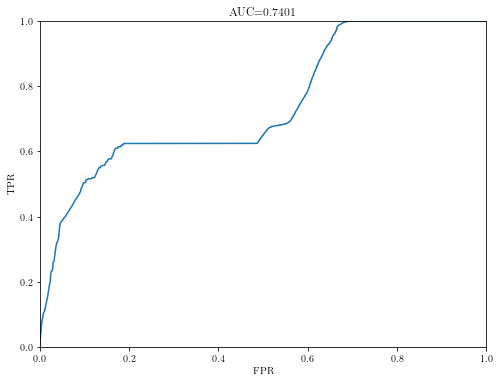

In [45]:
fpr, tpr, thresholds_roc = metrics.roc_curve(test_results["actual"], test_results["predicted"])

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)

plt.plot(fpr, tpr)
plt.title('AUC={:.4f}'.format(metrics.roc_auc_score(test_results["actual"], test_results["predicted"])))
plt.xlim(0, 1)
plt.ylim(0, 1)
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
plt.savefig('roc_metazoa.png')

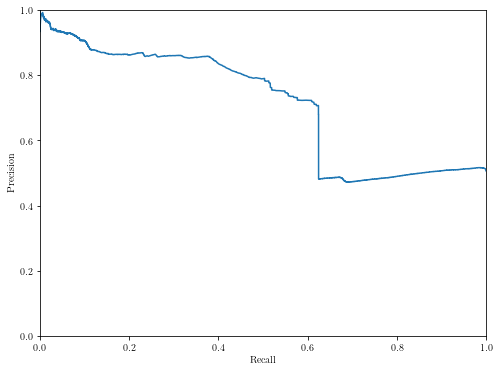

In [46]:
prec, rec, thresholds_recprec = metrics.precision_recall_curve(test_results["actual"], test_results["predicted"])
roc_data = pd.DataFrame({"Precision": prec, "Recall": rec})
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)

plt.plot(rec, prec)
plt.xlim(0, 1)
plt.ylim(0, 1)
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
plt.savefig('recprec_metazoa.png')

In [84]:
optimal_thr = 0.3

In [85]:
metrics.confusion_matrix(test_results["actual"], test_results["predicted"]>=optimal_thr)

array([[10243, 16193],
       [ 3212, 15942]])

In [86]:
metrics.accuracy_score(test_results["actual"], test_results["predicted"]>=optimal_thr)

0.5743584119324413

In [87]:
metrics.f1_score(test_results["actual"], test_results["predicted"]>=optimal_thr)

0.6216537659147185

### Whole tree quality correlations. Metazoa

In [64]:
import re

model = model.cpu()

incorrect_nodes_expect = [(re.findall('FastME|TNT', tree.filename[0].split('/')[-1])[0], re.findall(r'PF\d+_\d+', tree.filename[0].split('/')[-1])[0], torch.sum(model(tree)).item()) for tree in test_dataset]

/hspart/tools/miniconda3/envs/geom/lib/python3.8/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [65]:
predicted = pd.DataFrame(incorrect_nodes_expect, columns=['method', 'ID', 'ine'])
predicted = predicted.pivot(index='ID', columns='method', values='ine')

In [66]:
actual = pd.read_csv(data_path+'tree/Metazoa_RFdist.txt', sep='\t', index_col=0)

In [67]:
predicted.columns=['FastME_pred', 'TNT_pred']

In [68]:
data = pd.merge(actual, predicted, how='inner', on='ID')

In [69]:
data['Act_diff'] = data['TNT'] - data['FastME']
data['Pred_diff'] = data['TNT_pred'] - data['FastME_pred']

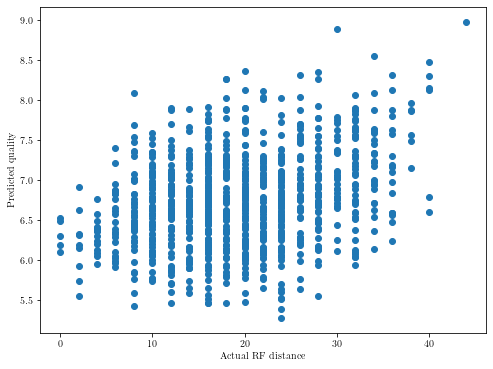

In [70]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)

plt.scatter(data['FastME'], data['FastME_pred'])
ax.set_xlabel('Actual RF distance')
ax.set_ylabel('Predicted quality')
plt.savefig('FastME_corr.png')

In [ ]:
spearmanr(data['FastME'], data['FastME_pred'])

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)

plt.scatter(data['TNT'], data['TNT_pred'])
ax.set_xlabel('Actual RF distance')
ax.set_ylabel('Predicted quality')
plt.savefig('TNT_corr.png')

In [ ]:
spearmanr(data['TNT'], data['TNT_pred'])

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)

plt.scatter(data['Act_diff'], data['Pred_diff'])
ax.set_xlabel('Actual RF distance difference')
ax.set_ylabel('Predicted difference')
plt.savefig('diff_corr.png')

In [ ]:
metrics.confusion_matrix(data['Act_diff']<0, data['Pred_diff']<0)

In [ ]:
fpr, tpr, thresholds_roc = metrics.roc_curve(data['Act_diff']<0, data['Pred_diff'])

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)

plt.plot(fpr, tpr)
plt.title('AUC={:.4f}'.format(metrics.roc_auc_score(data['Act_diff']<0, data['Pred_diff'])))
plt.xlim(0, 1)
plt.ylim(0, 1)
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
plt.savefig('whole_roc.png')

SpearmanrResult(correlation=0.27961670602187383, pvalue=6.993105806042725e-19)

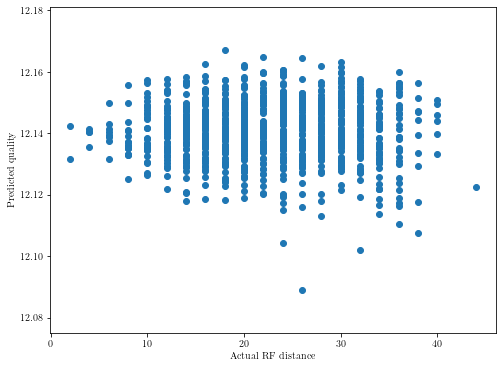

In [72]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)

plt.scatter(data['TNT'], data['TNT_pred'])
ax.set_xlabel('Actual RF distance')
ax.set_ylabel('Predicted quality')
plt.savefig('TNT_corr.png')

In [73]:
spearmanr(data['TNT'], data['TNT_pred'])

SpearmanrResult(correlation=0.02913454259387886, pvalue=0.36471752141544345)

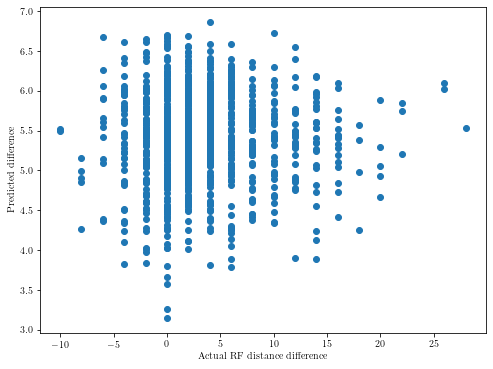

In [74]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)

plt.scatter(data['Act_diff'], data['Pred_diff'])
ax.set_xlabel('Actual RF distance difference')
ax.set_ylabel('Predicted difference')
plt.savefig('diff_corr.png')

In [75]:
metrics.confusion_matrix(data['Act_diff']<0, data['Pred_diff']<0)

array([[805,   0],
       [165,   0]])

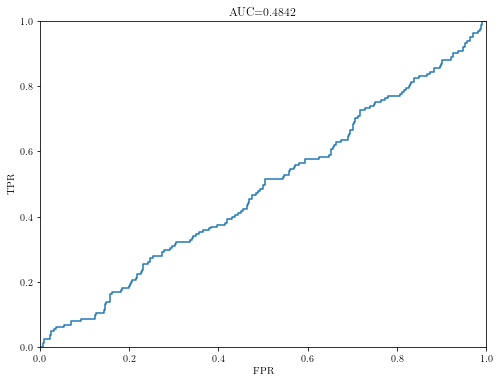

In [76]:
fpr, tpr, thresholds_roc = metrics.roc_curve(data['Act_diff']<0, data['Pred_diff'])

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)

plt.plot(fpr, tpr)
plt.title('AUC={:.4f}'.format(metrics.roc_auc_score(data['Act_diff']<0, data['Pred_diff'])))
plt.xlim(0, 1)
plt.ylim(0, 1)
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
plt.savefig('whole_roc.png')